# TP Audio

In [128]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras import layers, models
import hashlib
import sys
import random
import soundfile
import shutil
import copy

## Configuration

In [129]:
# Paramètres
NB_UNKNOWN_WORDS = 1
WANTED_WORDS = ["up", "down", "left", "right"]
for i in range(NB_UNKNOWN_WORDS):
    WANTED_WORDS.append("unknown_word")
SAMPLING_RATE = 16000
TIME_FRAME = 30  # ms
STRIDE = 10  # ms
N_MFCC = 40
DATA_DIR = "data"
UNKNOWN_WORDS = ["bed", "bird", "cat", "dog", "eight", "five", "four", "go", "happy", "house", "marvin", "nine", "no", "off", "on", "one", "seven", "sheila", "six", "stop", "three", "tree", "two", "wow", "yes", "zero"]
# SEED=42
# random.seed(SEED)
print("Actual random seed is:", random.getstate()[1][0])


Actual random seed is: 3552602870


## Extraction des features

In [130]:
def zero_pad(mfccs, max_pad_length):
    if mfccs.shape[1] < max_pad_length:
        pad_width = max_pad_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_length]
        
    return mfccs

def extract_features(file_path, max_pad_length=98):
    signal, sr = librosa.load(file_path, sr=SAMPLING_RATE)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=N_MFCC)
    
    mfccs = zero_pad(mfccs, max_pad_length)
    
    return mfccs

## Bruitage des données

In [131]:
def signal_mixture(s1, s2, p = 0.5):
    return [(i * p + j * (1-p)) for i, j in zip(s1, s2)]

def signal_align(s1, s2, delay = 0, verbose = False):
    d1, d2 = len(s1), len(s2)
    if delay < 0:
        delay = 0
        if verbose:
            print("Delay duration should not be negative, rectified to 0")
    if d1 > d2: # alors on va décaler s2 par rapport à s1 pour la superposition; 'delay' définit la marge de décalage
        if d2 + delay > d1: # dans le cas où le décalage dépasse la durée du signal
            delay = d1 - d2 # le décalage est rectifié
            if verbose:
                print("Delay duration exceeded end to longest signal, rectified to" + str(delay))
        out1 = s1[delay: delay + d2]
        out2 = s2
        assert len(out1) == d2
    elif d2 > d1: # alors on va décaler s1 par rapport à s2 pour la superposition; 'delay' définit la marge de décalage
        if d1 + delay > d2: # dans le cas où le décalage dépasse la durée du signal
            delay = d2 - d1 # le décalage est rectifié
            if verbose:
                print("Delay duration exceeded end to longest signal, rectified to" + str(delay))
        out1 = s1
        out2 = s2[delay: delay + d1]
        assert len(out2) == d1
    elif d1 == d2: # Cas rarissime, en théorie
        out1 = s1
        out2 = s2
    assert len(out1) == len(out2), str(len(out1)) + " ≠ " + str(len(out2))
    return out1, out2

def signal_resample(s1, s2, r1, r2, sup = True, verbose = False):
    if r1 > r2 and sup or r1 < r2 and not sup: # Si besoin, on normalise la résolution des signaux l’un par rapport à l’autre
        librosa.resample(y = s2, orig_sr = r2, target_sr = r1)
        if verbose:
            print("Different sample rates from the two signals, signal 2 resampled from "+str(r2)+" to "+str(r1))
        rr = r2
    elif r2 > r1 and sup or r2 < r1 and not sup:
        librosa.resample(y = s1, orig_sr = r1, target_sr = r2)
        if verbose:
            print("Different sample rates from the two signals, signal 1 resampled from "+str(r1)+" to "+str(r2))
        rr = r1
    else:
        if verbose:
            print("Sample rates from the two signals are identical")
        rr = r1
    return rr

def superposition(path_1, path_2, path_out, rate = None, delay = 0, prop = 0.5, verbose = False):
    assert 'librosa' in sys.modules, "This function needs 'librosa' module"
    assert 'soundfile' in sys.modules, "This function needs 'soundfile' module"
    assert type(delay) is int or type(delay) is float
    #d1, d2 = librosa.get_duration(path = path_1), librosa.get_duration(path = path_2)
    s1, r1 = librosa.load(path_1, sr = rate)
    s2, r2 = librosa.load(path_2, sr = rate) # Ne pas confondre les signaux et leur chemin dans le répertoire!
    d1, d2 = len(s1), len(s2)
    if verbose:
        print("First signal’s duration is " + str(d1) + " and its sample rate is " + str(r1))
        print("Second signal’s duration is "+ str(d2) + " and its sample rate is " + str(r2))
        print("Delay’s samples length is " + str(delay))
    
    if rate == None: # Si on laisse les valeurs par défaut des samplerates, il faut vérifier qu’ils sont égaux
        rr = signal_resample(s1, s2, r1, r2, True) # et resampler l’un des fichiers si besoin est
    else:
        rr = rate
    
    to_be_noised, noise_excerpt = signal_align(s1, s2, delay)
    the_final_cut = signal_mixture(to_be_noised, noise_excerpt, p = prop)
    soundfile.write(path_out, the_final_cut, rr, 'PCM_16')
    if verbose:
        print("File " + path_out + " succesfully written\n")
    s3, _ = librosa.load(path_out, sr = None)
    return s3

In [132]:
def get_filenames_from_dir(dir, suff = ""):
    assert 'os' in sys.modules, "This function needs 'os' module"
    return [dir + "/" + os.fsdecode(fname) for fname in sorted(os.listdir(dir)) if (fname.endswith(suff) or suff == "")]

def load_files(path_names, suff = ""):
    assert 'librosa' in sys.modules, "This function needs 'librosa' module"
    assert type(path_names) is str or type(path_names) is list
    if type(path_names) is str and path_names.endswith(suff):
        return librosa.load(path_names, sr = None)[0]
    elif type(path_names) is list: # liste des signaux
        for pathname in path_names:
            assert type(pathname) is str
        return [librosa.load(pathname, sr = None)[0] for pathname in path_names if (pathname.endswith(suff) or suff == "")]

In [133]:
le_noise = get_filenames_from_dir("data/_background_noise_", ".wav") # liste des noms de fichiers
print(le_noise)
background_noise = load_files(le_noise, ".wav")
for pathname in le_noise:
    print(pathname)
    print("Résolution:", librosa.get_samplerate(pathname))
    print("Durée:", librosa.get_duration(path = pathname))

['data/_background_noise_/doing_the_dishes.wav', 'data/_background_noise_/dude_miaowing.wav', 'data/_background_noise_/exercise_bike.wav', 'data/_background_noise_/pink_noise.wav', 'data/_background_noise_/running_tap.wav', 'data/_background_noise_/white_noise.wav']
data/_background_noise_/doing_the_dishes.wav
Résolution: 16000
Durée: 95.183125
data/_background_noise_/dude_miaowing.wav
Résolution: 16000
Durée: 61.8056875
data/_background_noise_/exercise_bike.wav
Résolution: 16000
Durée: 61.253875
data/_background_noise_/pink_noise.wav
Résolution: 16000
Durée: 60.0
data/_background_noise_/running_tap.wav
Résolution: 16000
Durée: 61.1555
data/_background_noise_/white_noise.wav
Résolution: 16000
Durée: 60.0


In [134]:
def clear_noise_data():
    dirpath = "data/noisy_dataset"
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        print("The noisy dataset already exists, i remove it")
        shutil.rmtree(dirpath)

def add_noise_to_dataset(_dataset: dict, dataset_name: str, ratio: float = 0.5, verbose: bool = False):
    dirpath = "data/noisy_dataset"
    if not os.path.exists(dirpath) or not os.path.isdir(dirpath):
        os.mkdir(dirpath)
    os.mkdir(os.path.join(dirpath, dataset_name))
    selected_dataset = _dataset[dataset_name].copy()
    i = 0
    for word in selected_dataset:
        i+=1
        print(f"Traitement {i}/{len(selected_dataset)} words type ({word})")
        if verbose:
            print(_dataset[dataset_name][word])  
        
        os.mkdir(os.path.join(dirpath, dataset_name, word))
        ## RAndome choice element in dateset to noise it but need to choose all different elements
        signal_to_noise = random.sample(selected_dataset[word], int(ratio * len(selected_dataset[word])))
        if verbose:
            print("signal_to_noise:", signal_to_noise)
        for filename in signal_to_noise:
            if verbose:
                print("Adding noise to", filename)
            noise = random.choice(le_noise)
            new_filename = os.path.join(dirpath, dataset_name, word, filename.split("\\")[-1])
            if verbose:
                print("new_filename:", new_filename)
            superposition(filename, noise, new_filename, prop=0.70)
            _dataset[dataset_name][word].remove(filename)
            _dataset[dataset_name][word].append(new_filename)
            if verbose:
                print(_dataset[dataset_name][word])
            

## DATASET Generation

In [135]:
def which_set(filename, validation_percentage=10, testing_percentage=10):
    """
    Détermine si un fichier doit aller dans l'ensemble d'entraînement, de validation ou de test.
    
    Args:
        filename: Nom du fichier audio
        validation_percentage: Pourcentage pour la validation (défaut: 10%)
        testing_percentage: Pourcentage pour le test (défaut: 10%)
    
    Returns:
        'training', 'validation', ou 'testing'
    """
    speaker_id = filename.split('_nohash_')[0]
    
    hash_obj = hashlib.sha1(speaker_id.encode())
    hash_value = int(hash_obj.hexdigest(), 16)
    
    percentage_hash = hash_value % 100
    
    if percentage_hash < testing_percentage:
        return 'testing'
    elif percentage_hash < testing_percentage + validation_percentage:
        return 'validation'
    else:
        return 'training'

In [136]:
def organize_balanced_dataset(data_dir, wanted_words, samples_per_word=3000, validation_percentage=10, testing_percentage=10):
    """
    Organise les fichiers audio avec un nombre fixe d'échantillons par mot.
    """
    word_files = {word: {} for word in wanted_words}
    speaker_sets = {}
    
    for word in wanted_words:
        if word == "unknown_word":
            for unknown_word in UNKNOWN_WORDS:
                word_dir = os.path.join(data_dir, unknown_word)
                if not os.path.exists(word_dir):
                    continue
                    
                files = [f for f in os.listdir(word_dir) if f.endswith('.wav')]
                for f in files:
                    speaker_id = f.split('_nohash_')[0]
                    if speaker_id not in word_files[word]:
                        word_files[word][speaker_id] = []
                    word_files[word][speaker_id].append(os.path.join(word_dir, f))
        else:
            word_dir = os.path.join(data_dir, word)
            if not os.path.exists(word_dir):
                continue
                
            files = [f for f in os.listdir(word_dir) if f.endswith('.wav')]
            for f in files:
                speaker_id = f.split('_nohash_')[0]
                if speaker_id not in word_files[word]:
                    word_files[word][speaker_id] = []
                word_files[word][speaker_id].append(os.path.join(word_dir, f))
    
    final_dataset = {
        'training': {word: [] for word in wanted_words},
        'validation': {word: [] for word in wanted_words},
        'testing': {word: [] for word in wanted_words}
    }
    
    for word in wanted_words:
        total_files = []
        speakers = list(word_files[word].keys())
        random.shuffle(speakers)
        
        for speaker in speakers:
            if len(total_files) >= samples_per_word:
                break
            total_files.extend(word_files[word][speaker])
        
        if len(total_files) > samples_per_word:
            total_files = random.sample(total_files, samples_per_word)
            
        for file in total_files:
            speaker_id = os.path.basename(file).split('_nohash_')[0]
            
            if speaker_id not in speaker_sets:
                set_name = which_set(speaker_id, validation_percentage, testing_percentage)
                speaker_sets[speaker_id] = set_name
            
            final_dataset[speaker_sets[speaker_id]][word].append(file)
    
    for word in wanted_words:
        n_validation = len(final_dataset['validation'][word])
        n_testing = len(final_dataset['testing'][word])
        n_training = len(final_dataset['training'][word])
        total = n_training + n_validation + n_testing
        
        print(f"\nStatistiques pour {word}:")
        print(f"Total: {total} fichiers")
        print(f"Training: {n_training} ({n_training/total*100:.1f}%)")
        print(f"Validation: {n_validation} ({n_validation/total*100:.1f}%)")
        print(f"Testing: {n_testing} ({n_testing/total*100:.1f}%)")
        
        if word == "unknown_word":
            print("\nDétail des unknown words par dossier source:")
            source_counts = {}
            for set_name in ['training', 'validation', 'testing']:
                for file in final_dataset[set_name][word]:
                    source_dir = os.path.basename(os.path.dirname(file))
                    source_counts[source_dir] = source_counts.get(source_dir, 0) + 1
            for source, count in source_counts.items():
                print(f"{source}: {count} fichiers")
    
    return final_dataset

dataset = organize_balanced_dataset(DATA_DIR, WANTED_WORDS, samples_per_word=3000)
print("\nExemple de fichiers d'entraînement pour 'up':")
print(dataset['training']['up'][:5])


Statistiques pour up:
Total: 3000 fichiers
Training: 2382 (79.4%)
Validation: 302 (10.1%)
Testing: 316 (10.5%)

Statistiques pour down:
Total: 3000 fichiers
Training: 2400 (80.0%)
Validation: 301 (10.0%)
Testing: 299 (10.0%)

Statistiques pour left:
Total: 3000 fichiers
Training: 2448 (81.6%)
Validation: 306 (10.2%)
Testing: 246 (8.2%)

Statistiques pour right:
Total: 3000 fichiers
Training: 2398 (79.9%)
Validation: 298 (9.9%)
Testing: 304 (10.1%)

Statistiques pour unknown_word:
Total: 3000 fichiers
Training: 2337 (77.9%)
Validation: 407 (13.6%)
Testing: 256 (8.5%)

Détail des unknown words par dossier source:
zero: 141 fichiers
four: 120 fichiers
off: 132 fichiers
tree: 65 fichiers
one: 134 fichiers
marvin: 77 fichiers
seven: 138 fichiers
bed: 79 fichiers
yes: 146 fichiers
dog: 88 fichiers
stop: 143 fichiers
on: 157 fichiers
go: 133 fichiers
eight: 119 fichiers
three: 124 fichiers
sheila: 85 fichiers
two: 131 fichiers
five: 135 fichiers
six: 133 fichiers
cat: 82 fichiers
nine: 146 f

In [ ]:
def prepare_dataset(_dataset):
    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []
    
    label_encoder = LabelEncoder()
    label_encoder.fit(WANTED_WORDS)
    
    for word in WANTED_WORDS:
        for file in _dataset['training'][word]:
            features = extract_features(file)
            X_train.append(features)
            y_train.append(word)
            
        for file in _dataset['validation'][word]:
            features = extract_features(file)
            X_val.append(features)
            y_val.append(word)
            
        for file in _dataset['testing'][word]:
            features = extract_features(file)
            X_test.append(features)
            y_test.append(word)
    
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    
    y_train = label_encoder.transform(y_train)
    y_val = label_encoder.transform(y_val)
    y_test = label_encoder.transform(y_test)
    
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(WANTED_WORDS))
    y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(WANTED_WORDS))
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=len(WANTED_WORDS))
    
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    print("Formes des données:")
    print(f"X_train: {X_train.shape}")
    print(f"X_val: {X_val.shape}")
    print(f"X_test: {X_test.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_val: {y_val.shape}")
    print(f"y_test: {y_test.shape}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test

## Construction des modèles

In [138]:
def build_model(model_type, X_train):
    if model_type == "vanilla":
        model = models.Sequential([
            layers.Flatten(input_shape=X_train.shape[1:]),
            layers.Dense(len(WANTED_WORDS), activation='softmax')
        ])
    elif model_type == "dnn":
        model = models.Sequential([
            layers.Flatten(input_shape=X_train.shape[1:]),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(WANTED_WORDS), activation='softmax')
        ])
    elif model_type == "cnn":
        model = models.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'), # i.e. fully-connected
            layers.Dense(len(WANTED_WORDS), activation='softmax')
        ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [152]:
def train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test, has_roc_curve=False):
    for name, model in models_dict.items():
        print(f"\nTraining {name} model...")
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

        y_pred = models_dict[name].predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)

        conf_mat = confusion_matrix(y_test_labels, y_pred_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=WANTED_WORDS, yticklabels=WANTED_WORDS)
        plt.xlabel("Prédictions")
        plt.ylabel("Réel")
        plt.title(f"Matrice de confusion - {name}")
        plt.show()

        # plt.savefig(f"confusion_matrix_{name}.png")
        if has_roc_curve:
            fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {name}')
            plt.legend(loc='lower right')
            plt.show()

        # plt.savefig(f"roc_curve_{name}.png")

        print("Classification Report:")
        print(classification_report(y_test_labels, y_pred_labels, target_names=WANTED_WORDS))


## Evaluation des modèles

In [140]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset)

Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)


In [ ]:
models_dict = {name: build_model(name, X_train=X_train) for name in ["vanilla", "dnn", "cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test, has_roc_curve=True)

d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TypeError: train_model() got an unexpected keyword argument 'roc_curve'

## Changement du nombre d'elements bruiter

### 10% des données bruitées

The noisy dataset already exists, i remove it
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)

Training cnn model...


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.4163 - loss: 2.0086 - val_accuracy: 0.7354 - val_loss: 0.7066
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.7744 - loss: 0.5945 - val_accuracy: 0.7615 - val_loss: 0.6267
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.8405 - loss: 0.4223 - val_accuracy: 0.8092 - val_loss: 0.5245
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.8836 - loss: 0.3169 - val_accuracy: 0.7844 - val_loss: 0.6403
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 26s 68ms/step - accuracy: 0.9068 - loss: 0.2485 - val_accuracy: 0.8079 - val_loss: 0.5590
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - accuracy: 0.9347 - loss: 0.1804 - val_accuracy: 0.8067 - val_loss: 0.7193
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.9565 - loss: 0.1287 - val_accuracy: 0.8067 - val_loss: 0.7446
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.9597 - loss: 0.1065 - 

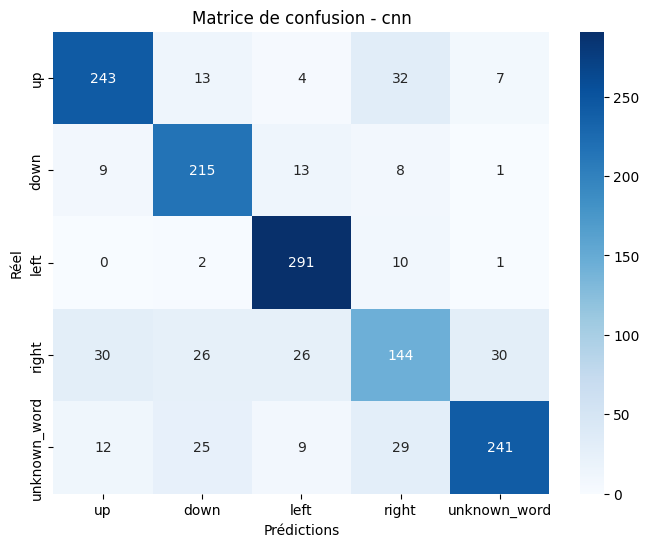

Classification Report:
              precision    recall  f1-score   support

          up       0.83      0.81      0.82       299
        down       0.77      0.87      0.82       246
        left       0.85      0.96      0.90       304
       right       0.65      0.56      0.60       256
unknown_word       0.86      0.76      0.81       316

    accuracy                           0.80      1421
   macro avg       0.79      0.79      0.79      1421
weighted avg       0.80      0.80      0.79      1421



In [142]:
clear_noise_data()
dataset_noisy = copy.deepcopy(dataset)
add_noise_to_dataset(dataset_noisy, "training", 0.1)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)

The noisy dataset already exists, i remove it
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)

Training cnn model...
Epoch 1/10


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 71ms/step - accuracy: 0.3489 - loss: 1.9755 - val_accuracy: 0.6177 - val_loss: 0.9704
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - accuracy: 0.6895 - loss: 0.8250 - val_accuracy: 0.6710 - val_loss: 0.8845
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.7843 - loss: 0.5803 - val_accuracy: 0.7435 - val_loss: 0.6921
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.8512 - loss: 0.3991 - val_accuracy: 0.7931 - val_loss: 0.6150
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.8923 - loss: 0.3005 - val_accuracy: 0.7794 - val_loss: 0.6970
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.9229 - loss: 0.2208 - val_accuracy: 0.7924 - val_loss: 0.6336
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.9436 - loss: 0.1539 - val_accuracy: 0.7881 - val_loss: 0.7341
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.9589 - loss: 0.1227 - val_accurac

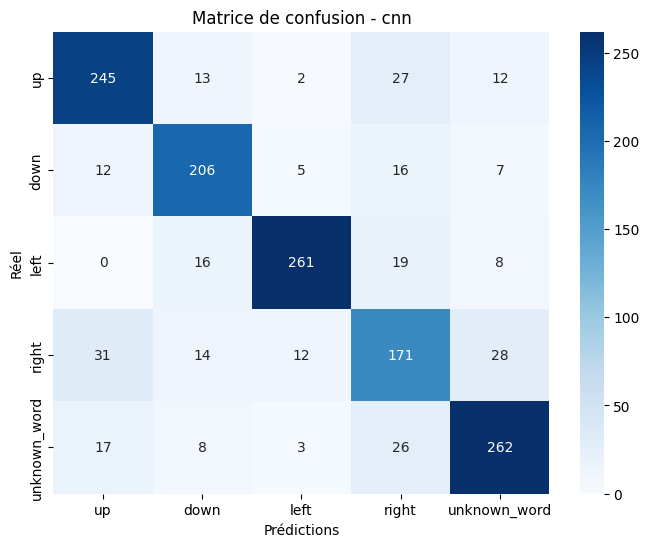

Classification Report:
              precision    recall  f1-score   support

          up       0.80      0.82      0.81       299
        down       0.80      0.84      0.82       246
        left       0.92      0.86      0.89       304
       right       0.66      0.67      0.66       256
unknown_word       0.83      0.83      0.83       316

    accuracy                           0.81      1421
   macro avg       0.80      0.80      0.80      1421
weighted avg       0.81      0.81      0.81      1421



In [143]:
clear_noise_data()
dataset_noisy = copy.deepcopy(dataset)

add_noise_to_dataset(dataset_noisy, "testing", 0.1)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)

The noisy dataset already exists, i remove it
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)

Training cnn model...


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 82ms/step - accuracy: 0.3354 - loss: 2.3222 - val_accuracy: 0.6561 - val_loss: 0.8646
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - accuracy: 0.7162 - loss: 0.7357 - val_accuracy: 0.7528 - val_loss: 0.6398
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 27s 72ms/step - accuracy: 0.8189 - loss: 0.4851 - val_accuracy: 0.7875 - val_loss: 0.5692
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.8564 - loss: 0.3828 - val_accuracy: 0.7788 - val_loss: 0.6056
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - accuracy: 0.8857 - loss: 0.3131 - val_accuracy: 0.8073 - val_loss: 0.5626
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 26s 69ms/step - accuracy: 0.9060 - loss: 0.2514 - val_accuracy: 0.8309 - val_loss: 0.5396
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9273 - loss: 0.2000 - val_accuracy: 0.7955 - val_loss: 0.6572
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 24s 64ms/step - accuracy: 0.9372 - loss: 0.1805 - 

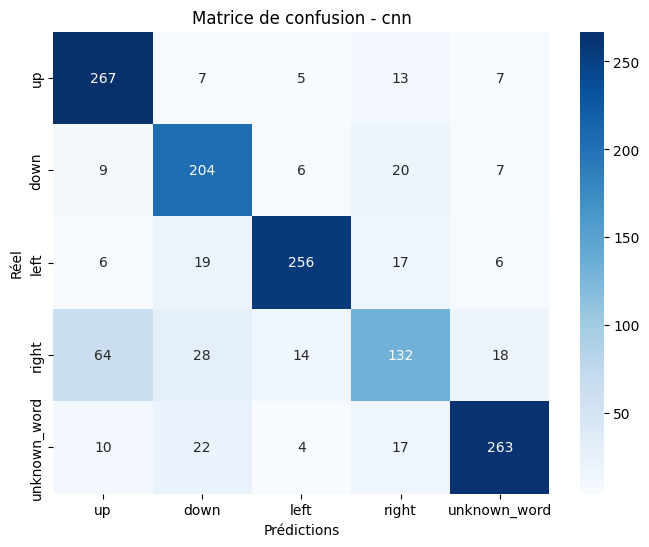

Classification Report:
              precision    recall  f1-score   support

          up       0.75      0.89      0.82       299
        down       0.73      0.83      0.78       246
        left       0.90      0.84      0.87       304
       right       0.66      0.52      0.58       256
unknown_word       0.87      0.83      0.85       316

    accuracy                           0.79      1421
   macro avg       0.78      0.78      0.78      1421
weighted avg       0.79      0.79      0.79      1421



In [144]:
dataset_noisy = copy.deepcopy(dataset)

clear_noise_data()
add_noise_to_dataset(dataset_noisy, "testing", 0.1)
add_noise_to_dataset(dataset_noisy, "training", 0.1)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)

### 20% des données bruitées

The noisy dataset already exists, i remove it
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training cnn model...
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 89ms/step - accuracy: 0.3192 - loss: 2.1517 - val_accuracy: 0.6097 - val_loss: 0.9569
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.6787 - loss: 0.8235 - val_accuracy: 0.7571 - val_loss: 0.6526
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.7903 - loss: 0.5614 - val_accuracy: 0.7782 - val_loss: 0.6256
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.8407 - loss: 0.4227 - val_accuracy: 0.7968 - val_loss: 0.5769
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.8801 - loss: 0.3294 - val_accuracy: 0.8005 - val_loss: 0.6385
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.8958 - loss: 0.2830 - val_accuracy: 0.8135 - val_loss: 0.6419
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9284 - loss: 0.2045 - val_accuracy: 0.7906 - val_loss: 0.7816
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0

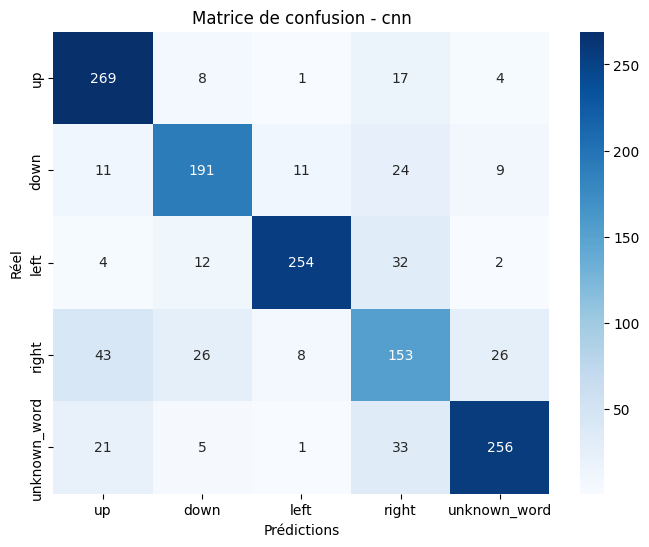

Classification Report:
              precision    recall  f1-score   support

          up       0.77      0.90      0.83       299
        down       0.79      0.78      0.78       246
        left       0.92      0.84      0.88       304
       right       0.59      0.60      0.59       256
unknown_word       0.86      0.81      0.84       316

    accuracy                           0.79      1421
   macro avg       0.79      0.78      0.78      1421
weighted avg       0.79      0.79      0.79      1421



In [145]:
dataset_noisy = copy.deepcopy(dataset)

clear_noise_data()
add_noise_to_dataset(dataset_noisy, "training", 0.2)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)

The noisy dataset already exists, i remove it


Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)

Training cnn model...


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.4714 - loss: 1.8082 - val_accuracy: 0.7243 - val_loss: 0.7359
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 92ms/step - accuracy: 0.8139 - loss: 0.5052 - val_accuracy: 0.7794 - val_loss: 0.6455
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 32s 87ms/step - accuracy: 0.8815 - loss: 0.3454 - val_accuracy: 0.8135 - val_loss: 0.5214
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9083 - loss: 0.2444 - val_accuracy: 0.8098 - val_loss: 0.5622
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9311 - loss: 0.1913 - val_accuracy: 0.8116 - val_loss: 0.6116
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9490 - loss: 0.1466 - val_accuracy: 0.8116 - val_loss: 0.6691
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step - accuracy: 0.9683 - loss: 0.0963 - val_accuracy: 0.8203 - val_loss: 0.6546
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.9733 - loss: 0.0736 - 

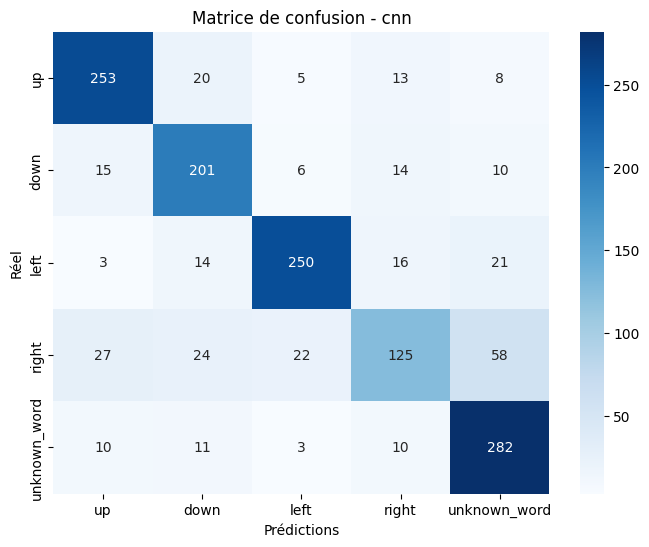

Classification Report:
              precision    recall  f1-score   support

          up       0.82      0.85      0.83       299
        down       0.74      0.82      0.78       246
        left       0.87      0.82      0.85       304
       right       0.70      0.49      0.58       256
unknown_word       0.74      0.89      0.81       316

    accuracy                           0.78      1421
   macro avg       0.78      0.77      0.77      1421
weighted avg       0.78      0.78      0.78      1421



In [146]:
dataset_noisy = copy.deepcopy(dataset)

clear_noise_data()
add_noise_to_dataset(dataset_noisy, "testing", 0.2)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)

The noisy dataset already exists, i remove it
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)

Training cnn model...


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 97ms/step - accuracy: 0.4112 - loss: 1.8801 - val_accuracy: 0.6772 - val_loss: 0.8234
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.7109 - loss: 0.7680 - val_accuracy: 0.7268 - val_loss: 0.7372
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.7892 - loss: 0.5629 - val_accuracy: 0.7565 - val_loss: 0.6706
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 100ms/step - accuracy: 0.8258 - loss: 0.4653 - val_accuracy: 0.7831 - val_loss: 0.6435
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.8701 - loss: 0.3535 - val_accuracy: 0.7906 - val_loss: 0.6238
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9005 - loss: 0.2795 - val_accuracy: 0.7838 - val_loss: 0.7129
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 103ms/step - accuracy: 0.9132 - loss: 0.2372 - val_accuracy: 0.7918 - val_loss: 0.6916
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.9397 - loss: 0.1713 

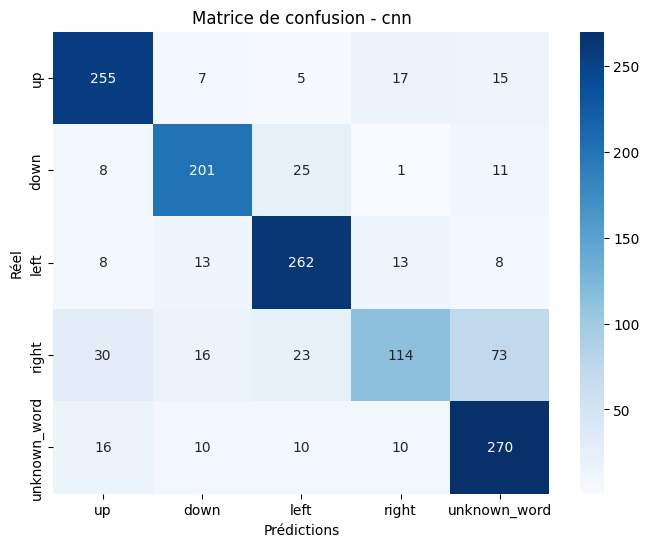

Classification Report:
              precision    recall  f1-score   support

          up       0.80      0.85      0.83       299
        down       0.81      0.82      0.82       246
        left       0.81      0.86      0.83       304
       right       0.74      0.45      0.55       256
unknown_word       0.72      0.85      0.78       316

    accuracy                           0.78      1421
   macro avg       0.78      0.77      0.76      1421
weighted avg       0.77      0.78      0.77      1421



In [147]:
dataset_noisy = copy.deepcopy(dataset)

clear_noise_data()
add_noise_to_dataset(dataset_noisy, "testing", 0.2)
add_noise_to_dataset(dataset_noisy, "training", 0.2)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)

### 50% des données bruitées

The noisy dataset already exists, i remove it
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)

Training cnn model...


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.3323 - loss: 1.9541 - val_accuracy: 0.5948 - val_loss: 1.0170
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.6401 - loss: 0.9258 - val_accuracy: 0.6933 - val_loss: 0.8801
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 37s 98ms/step - accuracy: 0.7522 - loss: 0.6570 - val_accuracy: 0.7175 - val_loss: 0.7504
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.8183 - loss: 0.4927 - val_accuracy: 0.7695 - val_loss: 0.6864
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.8613 - loss: 0.3780 - val_accuracy: 0.7485 - val_loss: 0.8024
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 93ms/step - accuracy: 0.8889 - loss: 0.3020 - val_accuracy: 0.7522 - val_loss: 0.9341
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9183 - loss: 0.2239 - val_accuracy: 0.7633 - val_loss: 1.0272
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9460 - loss: 0.1506 - 

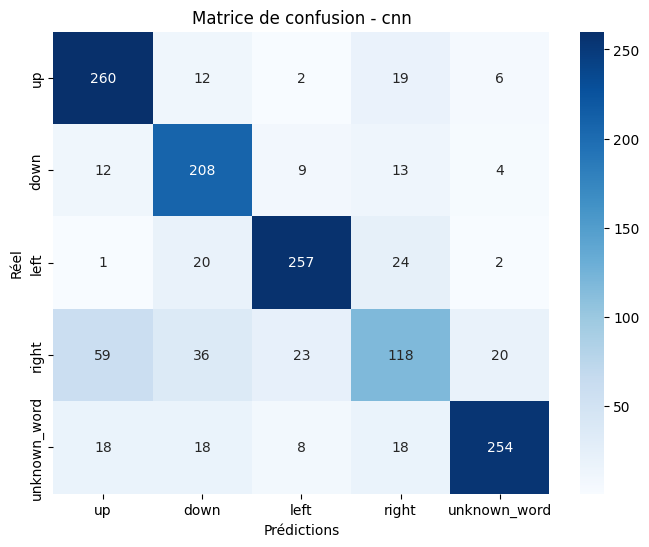

Classification Report:
              precision    recall  f1-score   support

          up       0.74      0.87      0.80       299
        down       0.71      0.85      0.77       246
        left       0.86      0.85      0.85       304
       right       0.61      0.46      0.53       256
unknown_word       0.89      0.80      0.84       316

    accuracy                           0.77      1421
   macro avg       0.76      0.77      0.76      1421
weighted avg       0.77      0.77      0.77      1421



In [148]:
dataset_noisy = copy.deepcopy(dataset)

clear_noise_data()
add_noise_to_dataset(dataset_noisy, "training", 0.5)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)

The noisy dataset already exists, i remove it
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)

Training cnn model...


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.3952 - loss: 2.0464 - val_accuracy: 0.6506 - val_loss: 0.9661
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 93ms/step - accuracy: 0.7482 - loss: 0.6653 - val_accuracy: 0.7156 - val_loss: 0.7464
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.8440 - loss: 0.4225 - val_accuracy: 0.7429 - val_loss: 0.7153
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.8936 - loss: 0.2823 - val_accuracy: 0.7881 - val_loss: 0.6297
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.9212 - loss: 0.2153 - val_accuracy: 0.7596 - val_loss: 0.7714
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.9476 - loss: 0.1460 - val_accuracy: 0.7726 - val_loss: 0.7886
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 34s 91ms/step - accuracy: 0.9606 - loss: 0.1119 - val_accuracy: 0.7553 - val_loss: 1.0108
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.9716 - loss: 0.0828 - 

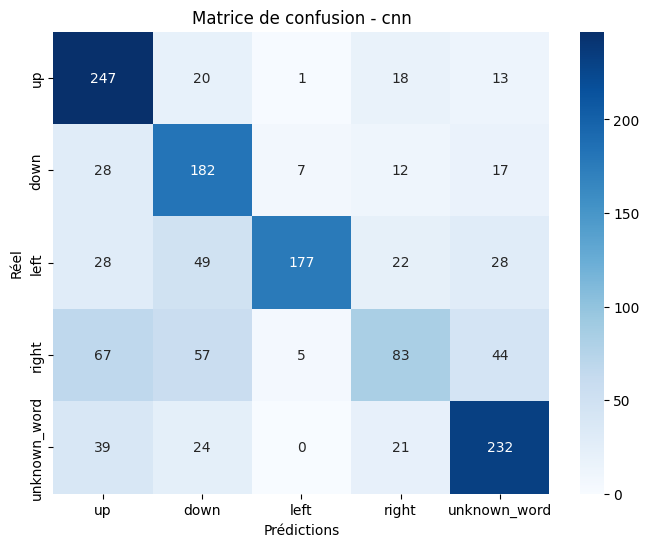

Classification Report:
              precision    recall  f1-score   support

          up       0.60      0.83      0.70       299
        down       0.55      0.74      0.63       246
        left       0.93      0.58      0.72       304
       right       0.53      0.32      0.40       256
unknown_word       0.69      0.73      0.71       316

    accuracy                           0.65      1421
   macro avg       0.66      0.64      0.63      1421
weighted avg       0.67      0.65      0.64      1421



In [149]:
dataset_noisy = copy.deepcopy(dataset)

clear_noise_data()
add_noise_to_dataset(dataset_noisy, "testing", 0.5)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)

The noisy dataset already exists, i remove it
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Traitement 1/5 words type (up)
Traitement 2/5 words type (down)
Traitement 3/5 words type (left)
Traitement 4/5 words type (right)
Traitement 5/5 words type (unknown_word)
Formes des données:
X_train: (11965, 40, 98, 1)
X_val: (1614, 40, 98, 1)
X_test: (1421, 40, 98, 1)
y_train: (11965, 5)
y_val: (1614, 5)
y_test: (1421, 5)


d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training cnn model...
Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 94ms/step - accuracy: 0.3832 - loss: 1.8132 - val_accuracy: 0.7354 - val_loss: 0.7072
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 92ms/step - accuracy: 0.6984 - loss: 0.7922 - val_accuracy: 0.7683 - val_loss: 0.6489
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 37s 99ms/step - accuracy: 0.7872 - loss: 0.5763 - val_accuracy: 0.7862 - val_loss: 0.5825
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 95ms/step - accuracy: 0.8601 - loss: 0.3924 - val_accuracy: 0.7602 - val_loss: 0.7666
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 39s 104ms/step - accuracy: 0.8847 - loss: 0.3178 - val_accuracy: 0.8116 - val_loss: 0.7322
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 36s 97ms/step - accuracy: 0.9119 - loss: 0.2460 - val_accuracy: 0.8135 - val_loss: 0.6890
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 35s 94ms/step - accuracy: 0.9284 - loss: 0.2023 - val_accuracy: 0.7949 - val_loss: 0.8156
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - accuracy:

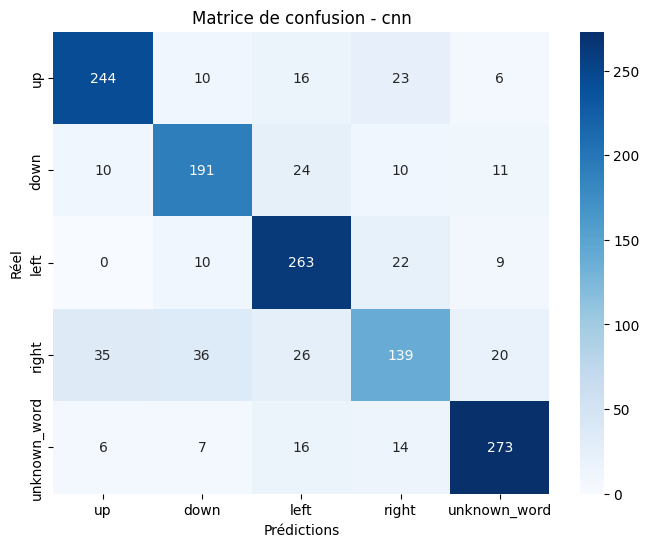

Classification Report:
              precision    recall  f1-score   support

          up       0.83      0.82      0.82       299
        down       0.75      0.78      0.76       246
        left       0.76      0.87      0.81       304
       right       0.67      0.54      0.60       256
unknown_word       0.86      0.86      0.86       316

    accuracy                           0.78      1421
   macro avg       0.77      0.77      0.77      1421
weighted avg       0.78      0.78      0.78      1421



In [150]:
dataset_noisy = copy.deepcopy(dataset)

clear_noise_data()
add_noise_to_dataset(dataset_noisy, "testing", 0.5)
add_noise_to_dataset(dataset_noisy, "training", 0.5)
X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(dataset_noisy)
models_dict = {name: build_model(name, X_train=X_train) for name in ["cnn"]}
train_model(models_dict, X_train, y_train, X_val, y_val, X_test, y_test)